<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN1_A3_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input


In [3]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/crop_part1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170109140259136.jpg.

In [56]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

In [5]:
def categorize_age(age):
    for range_name, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return range_name
    return None

In [6]:
def parse_age_from_filename(filename):
    parts = tf.strings.split(filename, os.sep)[-1]  # Get the filename from the path
    age_part = tf.strings.split(parts, '_')[0]  # Extract the age part
    age = tf.strings.to_number(age_part, tf.float32)
    return age

In [7]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to the input size expected by your model
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [8]:
def load_and_preprocess(path):
    age = parse_age_from_filename(path)
    image = load_and_preprocess_image(path)
    age_range = tf.numpy_function(categorize_age, [age], tf.string)
    return image, age_range

In [9]:
dataset_dir = '/content/crop_part1'
# Get the list of all image file paths

image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir) if fname.endswith('.jpg')]
print(f"Images shape: {len(image_paths)}")

Images shape: 9780


In [10]:
# Extract age labels from filenames
ages = [int(fname.split('_')[0]) for fname in os.listdir(dataset_dir) if fname.endswith('.jpg')]
print(f"Ages shape: {len(ages)}")


Ages shape: 9780


In [11]:
# Categorize ages into ranges
age_categories = [categorize_age(age) for age in ages]

In [12]:
# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, age_categories, stratify=age_categories, test_size=0.2, random_state=42)


In [13]:
import collections
# Function to print the distribution of age ranges
def print_age_distribution(labels, dataset_type):
    counter = collections.Counter(labels)
    print(f"{dataset_type} Age Distribution:")
    for age_range, count in counter.items():
        print(f"Age range {age_range}: {count} samples")

# Print distribution for training set
print_age_distribution(train_labels, "Training")

# Print distribution for validation set
print_age_distribution(val_labels, "Validation")

Training Age Distribution:
Age range 6: 800 samples
Age range 1: 1087 samples
Age range 5: 1347 samples
Age range 2: 1057 samples
Age range 4: 1368 samples
Age range 0: 1270 samples
Age range 3: 895 samples
Validation Age Distribution:
Age range 5: 337 samples
Age range 4: 342 samples
Age range 0: 317 samples
Age range 1: 272 samples
Age range 3: 224 samples
Age range 6: 200 samples
Age range 2: 264 samples


In [14]:
def load_and_preprocess(path, is_training=False):
    age = parse_age_from_filename(path)
    image = load_and_preprocess_image(path)
    age_range = tf.numpy_function(categorize_age, [age], tf.int64)
    age_range.set_shape([])  # Ensure the shape is set correctly
    age_range = tf.one_hot(age_range, len(age_ranges))
    return image, age_range

In [15]:
# Create TensorFlow datasets from the file paths
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)

In [16]:
# Apply the preprocessing functions to the datasets
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [17]:
# Shuffle, batch, and prefetch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


In [19]:
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_updated.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)

In [20]:
# Train your model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=60, callbacks=[model_checkpoint])

Epoch 1/60
245/245 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.5907
Epoch 1: val_accuracy improved from -inf to 0.17485, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_updated.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 89s 201ms/step - loss: 1.0079 - accuracy: 0.5907 - val_loss: 2.0537 - val_accuracy: 0.1748
Epoch 2/60
245/245 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.7832
Epoch 2: val_accuracy improved from 0.17485 to 0.18405, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_updated.h5
245/245 [==============================] - 45s 178ms/step - loss: 0.5552 - accuracy: 0.7832 - val_loss: 2.1968 - val_accuracy: 0.1840
Epoch 3/60
245/245 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8883
Epoch 3: val_accuracy improved from 0.18405 to 0.21677, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_updated.h5
245/245 [==============================] - 45s 178ms/step - loss: 0.3045 - accuracy: 0.8883 - val_loss: 2.0374 - val_accuracy: 0.2168
Epoch 4/60
245/245 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9374
Epoch 4: val_a

In [21]:
# Save the training history
history_dict = history.history

# Plot the training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

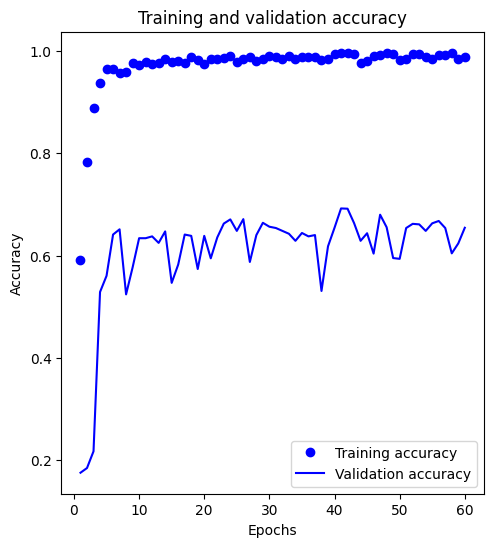

In [22]:
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

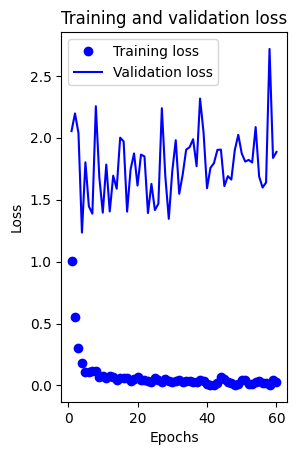

In [23]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [27]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_updated.h5')
# Evaluate the model
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


62/62 [==============================] - 3s 49ms/step - loss: 1.7576 - accuracy: 0.6922
Validation Loss: 1.757646083831787
Validation Accuracy: 0.6922290325164795


In [28]:
representative_ages = [np.mean(rng) for rng in age_ranges]

In [29]:
# Convert predictions and true labels back to representative ages
y_pred = model.predict(val_dataset)
y_pred_ages = [representative_ages[np.argmax(pred)] for pred in y_pred]

# Since val_labels is one-hot encoded, convert it to a numpy array and then to representative ages
val_labels_np = np.concatenate([y for x, y in val_dataset], axis=0)
y_true_ages = [representative_ages[np.argmax(true)] for true in val_labels_np]

# Calculate MAE
mae = np.mean(np.abs(np.array(y_true_ages) - np.array(y_pred_ages)))
print(f'Test MAE: {mae:.2f}')

62/62 [==============================] - 4s 46ms/step
Test MAE: 5.56


In [30]:
# Calculate MAE for each age range
age_range_mae = {}
for idx, age_range in enumerate(age_ranges):
    # Get the indices for the current age range
    range_indices = [i for i, age in enumerate(y_true_ages) if age_range[0] <= age <= age_range[1]]

    if range_indices:
        # Calculate MAE for the current age range
        y_true_range = np.array([y_true_ages[i] for i in range_indices])
        y_pred_range = np.array([y_pred_ages[i] for i in range_indices])

        mae = np.mean(np.abs(y_true_range - y_pred_range))
        age_range_mae[age_range] = mae

# Print MAE for each age range
for age_range, mae in age_range_mae.items():
    print(f"Age Range {age_range}: MAE = {mae:.2f}")

Age Range (1, 2): MAE = 1.03
Age Range (3, 9): MAE = 2.85
Age Range (10, 20): MAE = 3.65
Age Range (21, 27): MAE = 4.95
Age Range (28, 45): MAE = 6.73
Age Range (46, 65): MAE = 9.08
Age Range (66, 116): MAE = 11.69


In [32]:
# Make predictions on the validation dataset
predictions = model.predict(val_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
# Note: val_labels_np should be a concatenation of one-hot encoded labels from val_dataset
val_labels_np = np.concatenate([y for x, y in val_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Optionally, print some of the predicted and true class labels to verify
print("Sample predicted classes:", predicted_classes[:10])
print("Sample true classes:", true_classes[:10])

62/62 [==============================] - 3s 46ms/step
Sample predicted classes: [3 0 6 6 5 0 6 1 1 3]
Sample true classes: [5 5 4 5 5 0 5 1 1 3]


In [34]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.69
Precision: 0.70
Recall: 0.69
F1-score: 0.69


In [57]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [58]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.90
Accuracy for age range 3-9: 0.74
Accuracy for age range 10-20: 0.66
Accuracy for age range 21-27: 0.56
Accuracy for age range 28-45: 0.61
Accuracy for age range 46-65: 0.66
Accuracy for age range 66-116: 0.69


In [61]:
# Example metrics calculation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.90      0.90      0.90       317
         3-9       0.71      0.74      0.73       272
       10-20       0.62      0.66      0.64       264
       21-27       0.51      0.56      0.53       224
       28-45       0.63      0.61      0.62       342
       46-65       0.68      0.66      0.67       337
      66-116       0.81      0.69      0.75       200

    accuracy                           0.69      1956
   macro avg       0.69      0.69      0.69      1956
weighted avg       0.70      0.69      0.69      1956


Confusion Matrix:
[[286  28   0   1   0   0   2]
 [ 30 201  34   2   1   2   2]
 [  0  45 175  31  13   0   0]
 [  0   2  51 125  44   2   0]
 [  0   3  15  68 207  46   3]
 [  1   2   5  18  64 221  26]
 [  0   1   1   2   1  56 139]]


62/62 [==============================] - 3s 46ms/step
Confusion matrix, without normalization


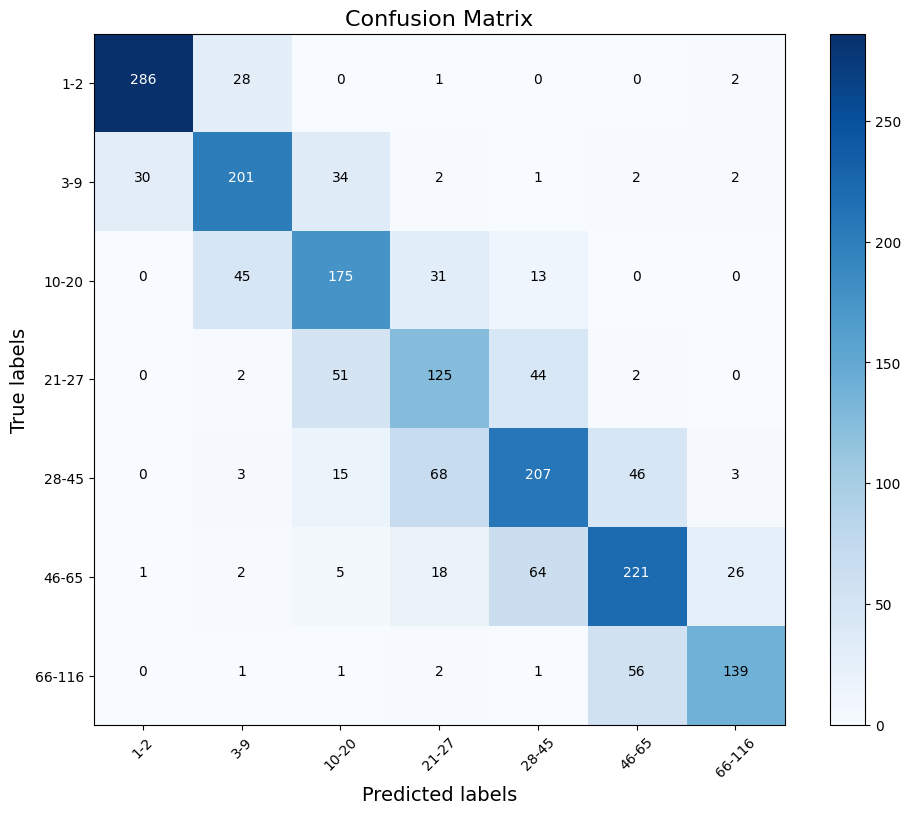

In [62]:
import itertools

# Define your function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

# Make predictions on the validation dataset
predictions = model.predict(val_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
val_labels_np = np.concatenate([y for x, y in val_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Age range labels
age_range_labels = [f'{start}-{end}' for start, end in age_ranges]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=age_range_labels, title='Confusion Matrix')
plt.show()